# Fine-tuning on clinical samples
In this notebook, we'll demonstrate fine-tuning a CNN on clinical samples to illustrate the procedure described in the `Extension to clinical isolates` section and also in the `CNN architecture & training details` section in the Methods.

## Load clinical data and pre-trained CNN
The first step is to load the clinical data that we're going to use for fine-tuning. This first set of data was collected in 2018.

In [1]:
from time import time
t00 = time()
import numpy as np

In [2]:
# Load clinical data
X_fn = './data/X_2018clinical.npy'
y_fn = './data/y_2018clinical.npy'
X = np.load(X_fn)
y = np.load(y_fn)
print(X.shape, y.shape)

(10000, 1000) (10000,)


Next, we load the ResNet model that has been pre-trained for the 8 class antibiotic treatment groupings task on the reference dataset.

In [3]:
from resnet import ResNet
import os
import torch

In [4]:
# CNN parameters
layers = 6
hidden_size = 100
block_size = 2
hidden_sizes = [hidden_size] * layers
num_blocks = [block_size] * layers
input_dim = 1000
in_channels = 64
n_classes = 8 # instead of 30, we use the 8 empiric groupings
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(0)
cuda = torch.cuda.is_available()

In [5]:
# Load trained weights for demo
cnn = ResNet(hidden_sizes, num_blocks, input_dim=input_dim,
                in_channels=in_channels, n_classes=n_classes)
if cuda: cnn.cuda()
cnn.load_state_dict(torch.load(
    './clinical_pretrained_model.ckpt', map_location=lambda storage, loc: storage))

## Fine-tuning
Now we can fine-tune the pre-trained CNN on our first set of clinical samples. In the experiments reported in the paper, we fine-tune within a cross-validation loop, but here we show just one fold for clarity. We also only train for one epoch here in the interest of time.

### Train/val/test split
For the clinical experiments, we need to be careful about splitting our spectra into training, validation, and test sets for each fold. In particular, we want to make sure that spectra from the same patient do not appear in both training and validation/test.

Our 2018 clinical dataset contains 400 spectra from each of 25 patients (10k spectra total), with 5 patients coming from each of the 5 empiric treatment groups. For each treatment group, we randomly assign 3 patients to the training set, 1 patient to validation, and 1 patient to the test set. We then randomly sample 10 spectra from each patient for fine-tuning, validation, and testing -- this is to simulate a culture-free clinical setting where not many bacterial spectra may be available.

The following code demonstrates how this procedure can be implemented for a single fold.

In [6]:
# For each treatment group of 5 patients, patients are assigned to [train, train, train, val, test]
patient_idxs = []
for i in range(5):
    x = list(range(5))
    np.random.shuffle(x)
    patient_idxs.append(x)

In [7]:
# Sample train/val/te spectra
idx_tr, idx_val, idx_te = [], [], []
for group_idx, patient_list in enumerate(patient_idxs):
    print('Group {} patients'.format(group_idx))
    print(' Tr: {}'.format(patient_list[:3]))
    print(' Val: {}'.format(patient_list[3]))
    print(' Te : {}'.format(patient_list[4]))
    for j, patient in enumerate(patient_list):
        start_idx = 5 * 400 * group_idx + 400 * patient
        idx_range = list(range(start_idx, start_idx+400))
        # Randomly sample 10 spectra for each patient
        np.random.shuffle(idx_range)
        idx_sample = idx_range[:10]
        if j < 3:
            idx_tr.extend(idx_sample)
        elif j ==3:
            idx_val.extend(idx_sample)
        else:
            idx_te.extend(idx_sample)

Group 0 patients
 Tr: [3, 1, 2]
 Val: 4
 Te : 0
Group 1 patients
 Tr: [3, 2, 1]
 Val: 4
 Te : 0
Group 2 patients
 Tr: [1, 3, 2]
 Val: 4
 Te : 0
Group 3 patients
 Tr: [2, 1, 3]
 Val: 0
 Te : 4
Group 4 patients
 Tr: [2, 0, 1]
 Val: 4
 Te : 3


### Fine-tune the pre-trained CNN
Now that we've split our clinical data, we can fine-tune the pre-trained model on the clinical data.

In [8]:
from datasets import spectral_dataloader
from training import run_epoch
from torch import optim

In [9]:
# Fine-tune CNN
epochs = 1 # Change this number to ~30 for full training
batch_size = 10
t0 = time()
# Set up Adam optimizer
optimizer = optim.Adam(cnn.parameters(), lr=1e-3, betas=(0.5, 0.999))
# Set up dataloaders
dl_tr = spectral_dataloader(X, y, idxs=idx_tr,
    batch_size=batch_size, shuffle=True)
dl_val = spectral_dataloader(X, y, idxs=idx_val,
    batch_size=batch_size, shuffle=False)
dl_te = spectral_dataloader(X, y, idxs=idx_te,
    batch_size=batch_size, shuffle=False)
# Fine-tune CNN for first fold
best_val = 0
no_improvement = 0
max_no_improvement = 5
print('Starting fine-tuning!')
for epoch in range(epochs):
    print(' Epoch {}: {:0.2f}s'.format(epoch+1, time()-t0))
    # Train
    acc_tr, loss_tr = run_epoch(epoch, cnn, dl_tr, cuda,
        training=True, optimizer=optimizer)
    print('  Train acc: {:0.2f}'.format(acc_tr))
    # Val
    acc_val, loss_val = run_epoch(epoch, cnn, dl_val, cuda,
        training=False, optimizer=optimizer)
    print('  Val acc: {:0.2f}'.format(acc_val))
    # Test
    acc_te, loss_te = run_epoch(epoch, cnn, dl_te, cuda,
        training=False, optimizer=optimizer)
    print('  Test acc: {:0.2f}'.format(acc_te))
    # Check performance for early stopping
    if acc_val > best_val or epoch == 0:
        best_val = acc_val
        no_improvement = 0
    else:
        no_improvement += 1
    if no_improvement >= max_no_improvement:
        print('Finished after {} epochs!'.format(epoch+1))
        break
print('Finished: {:0.2f}s'.format(time()-t0))

Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 92.00
  Val acc: 74.00
  Test acc: 96.00
Finished: 15.34s


## Make predictions on treatment groups for test patients
Now that we have a fine-tuned model, we demonstrate how it can be used for the analysis presented in Figure 4

In [10]:
# Getting test indices
idx_te = []
for group_idx, patient_list in enumerate(patient_idxs):
    start_idx = 5 * 400 * group_idx + 400 * patient_list[-1]
    idx_te += list(range(start_idx, start_idx+400))
dl_te = spectral_dataloader(X, y, idxs=idx_te,
    batch_size=batch_size, shuffle=False)

In [11]:
from training import get_predictions
from scipy import stats

In [12]:
t0 = time()
# Make predictions on the 5 test patients
y_hat = get_predictions(cnn, dl_te, cuda)
# Subset y according to which patients are chosen for the test set to generate y_te
y_te = y[idx_te]
print('Finished: {:0.2f}s'.format(time()-t0))

Finished: 46.68s


### Generate predictions of treatment groups
We use 10 spectra per patient to make our treatment group predictions. Here we only make predictions for one set of 5 test patients; in the experiments reported in the paper, we fine-tune within a cross-validation loop to cycle all patients through the test set. To compute identification accuracies across all patients, repeat the fine-tuning process in a cross-validation loop so that each patient appears in the test set once.

In [13]:
t0 = time()

# Experiment parameters
trials = 10000
n_spectra = 10

preds2018 = np.zeros((5,trials))
y_2018 = np.zeros((5, trials))

for i in range(5):
    y_2018[i] = y_te[400*i]
    for k  in range(trials):
        y_patient = y_hat[400*i:400*i+400]
        idxs = np.random.permutation(np.arange(len(y_patient)))[:n_spectra]
        preds2018[i,k] = stats.mode(y_patient[idxs])[0][0]

print('Ran {} trials: {:0.2f}s'.format(trials, time()-t0))

Ran 10000 trials: 3.98s


In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from config import antibiotics, ab_order
%matplotlib inline

/anaconda3/envs/inkjet/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


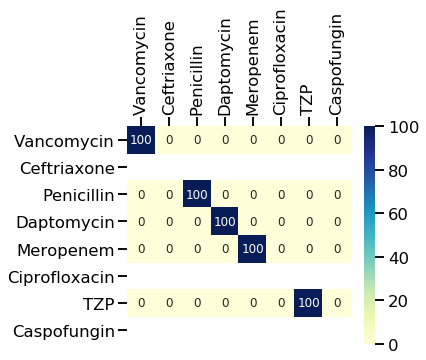

In [15]:
sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [antibiotics[i] for i in ab_order]
cm = confusion_matrix(y_2018.flatten(), preds2018.flatten(), labels=ab_order)
plt.figure(figsize=(5, 4))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

## Fine-tuning on new clinical datasets
In addition to fine-tuning on a first set of clinical data, we can continue to fine-tune the CNN on new clinical datasets. We use a dataset collected from new patients in 2019. As above, we show just one fold for clarity and train for only one epoch.

In [16]:
# Load 2019 clinical data
X_fn = './data/X_2019clinical.npy'
y_fn = './data/y_2019clinical.npy'
X = np.load(X_fn)
y = np.load(y_fn)
print(X.shape, y.shape)

(2500, 1000) (2500,)


### Train/val/test split
We split our patients into training, validation, and test sets for each fold, as above.

Our 2019 clinical dataset contains 100 spectra from each of 25 patients (2500 spectra total), with 5 patients coming from each of the 5 empiric treatment groups.

In [17]:
# For each treatment group of 5 patients, patients are assigned to [train, train, train, val, test]
patient_idxs = []
for i in range(5):
    x = list(range(5))
    np.random.shuffle(x)
    patient_idxs.append(x)

In [18]:
# Sample train/val/te spectra
idx_tr, idx_val, idx_te = [], [], []
for group_idx, patient_list in enumerate(patient_idxs):
    print('Group {} patients'.format(group_idx))
    print(' Tr: {}'.format(patient_list[:3]))
    print(' Val: {}'.format(patient_list[3]))
    print(' Te : {}'.format(patient_list[4]))
    for j, patient in enumerate(patient_list):
        start_idx = 5 * 100 * group_idx + 100 * patient
        idx_range = list(range(start_idx, start_idx+100))
        # Randomly sample 10 spectra for each patient
        np.random.shuffle(idx_range)
        idx_sample = idx_range[:10]
        if j < 3:
            idx_tr.extend(idx_sample)
        elif j ==3:
            idx_val.extend(idx_sample)
        else:
            idx_te.extend(idx_sample)

Group 0 patients
 Tr: [2, 3, 0]
 Val: 1
 Te : 4
Group 1 patients
 Tr: [3, 2, 0]
 Val: 1
 Te : 4
Group 2 patients
 Tr: [3, 4, 1]
 Val: 2
 Te : 0
Group 3 patients
 Tr: [4, 1, 0]
 Val: 3
 Te : 2
Group 4 patients
 Tr: [2, 3, 1]
 Val: 0
 Te : 4


### Continue fine-tuning the CNN
We use the new 2019 data to continue fine-tining the CNN that has already been fine-tuned on the 2018 data.

In [19]:
# Fine-tune CNN
epochs = 1 # Change this number to ~30 for full training
batch_size = 10
t0 = time()
# Set up Adam optimizer
optimizer = optim.Adam(cnn.parameters(), lr=1e-3, betas=(0.5, 0.999))
# Set up dataloaders
dl_tr = spectral_dataloader(X, y, idxs=idx_tr,
    batch_size=batch_size, shuffle=True)
dl_val = spectral_dataloader(X, y, idxs=idx_val,
    batch_size=batch_size, shuffle=False)
dl_te = spectral_dataloader(X, y, idxs=idx_te,
    batch_size=batch_size, shuffle=False)
# Fine-tune CNN for first fold
best_val = 0
no_improvement = 0
max_no_improvement = 5
print('Starting fine-tuning!')
for epoch in range(epochs):
    print(' Epoch {}: {:0.2f}s'.format(epoch+1, time()-t0))
    # Train
    acc_tr, loss_tr = run_epoch(epoch, cnn, dl_tr, cuda,
        training=True, optimizer=optimizer)
    print('  Train acc: {:0.2f}'.format(acc_tr))
    # Val
    acc_val, loss_val = run_epoch(epoch, cnn, dl_val, cuda,
        training=False, optimizer=optimizer)
    print('  Val acc: {:0.2f}'.format(acc_val))
    # Test
    acc_te, loss_te = run_epoch(epoch, cnn, dl_te, cuda,
        training=False, optimizer=optimizer)
    print('  Test acc: {:0.2f}'.format(acc_te))
    # Check performance for early stopping
    if acc_val > best_val or epoch == 0:
        best_val = acc_val
        no_improvement = 0
    else:
        no_improvement += 1
    if no_improvement >= max_no_improvement:
        print('Finished after {} epochs!'.format(epoch+1))
        break
print('Finished: {:0.2f}s'.format(time()-t0))

Starting fine-tuning!
 Epoch 1: 0.02s
  Train acc: 93.33
  Val acc: 84.00
  Test acc: 84.00
Finished: 11.85s


## Make predictions on treatment groups for test patients
As above, we make predictions for one group of 5 test patients.

In [20]:
# Getting test indices
idx_te = []
for group_idx, patient_list in enumerate(patient_idxs):
    start_idx = 5 * 100 * group_idx + 100 * patient_list[-1]
    idx_te += list(range(start_idx, start_idx+100))
dl_te = spectral_dataloader(X, y, idxs=idx_te,
    batch_size=batch_size, shuffle=False)

In [21]:
t0 = time()
# Make predictions on the 5 test patients
y_hat = get_predictions(cnn, dl_te, cuda)
# Subset y according to which patients are chosen for the test set to generate y_te
y_te = y[idx_te]
print('Finished: {:0.2f}s'.format(time()-t0))

Finished: 11.86s


### Generate predictions of treatment groups
We use 10 spectra per patient to make our treatment group predictions for 5 patients. To compute identification accuracies across all patients, repeat the fine-tuning process in a cross-validation loop so that each patient appears in the test set once.

In [22]:
t0 = time()

# Experiment parameters
trials = 10000
n_spectra = 10

preds2019 = np.zeros((5,trials))
y_2019 = np.zeros((5, trials))

for i in range(5):
    y_2019[i] = y_te[100*i]
    for k  in range(trials):
        y_patient = y_hat[100*i:100*i+100]
        idxs = np.random.permutation(np.arange(len(y_patient)))[:n_spectra]
        preds2019[i,k] = stats.mode(y_patient[idxs])[0][0]

print('Ran {} trials: {:0.2f}s'.format(trials, time()-t0))

Ran 10000 trials: 3.73s


/anaconda3/envs/inkjet/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


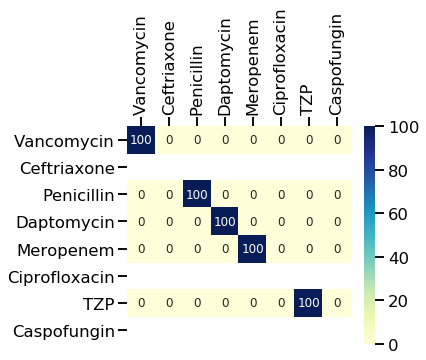


 This demo was completed in: 96.60s


In [23]:
sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [antibiotics[i] for i in ab_order]
cm = confusion_matrix(y_2019.flatten(), preds2019.flatten(), labels=ab_order)
plt.figure(figsize=(5, 4))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

print('\n This demo was completed in: {:0.2f}s'.format(time()-t00))